In [1]:
import torch
from torch import nn
from torch.backends import cudnn
from torch import optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import weight_norm
import torchvision
import datetime
import pandas as pd
import numpy as np


class DatasetLoader(Dataset):
    def __init__(self, csv_file, normalize=True):
        df = pd.read_csv(csv_file)
        df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
        df = df.set_index("timestamp")
        df = df.resample("15min").max().interpolate()
        df["value"] = df["value"].astype(np.float32)
        arr_value = df.value
        min_seq = min(
            [df.loc[df.index.day == d].shape[0] for d in df.index.day.unique().tolist()]
        )
        data = torch.from_numpy(
            np.expand_dims(
                np.array(
                    [
                        group[1].to_numpy().tolist()[:min_seq]
                        for group in arr_value.groupby(df.index.date)
                    ]
                ),
                -1,
            )
        ).float()
        self.seq_len = data.size(1)
        self.data = self.normalize(data) if normalize else data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    def normalize(self, x):
        self.max = x.max()
        self.min = x.min()
        return 2 * (x - x.min()) / (x.max() - x.min()) - 1

    def denormalize(self, x):
        return 0.5 * (x * self.max - x * self.min + self.max + self.min)

In [2]:
nz_dim = 100
params = {"learning_rate": 0.0005, "epochs": 200, "batch_size": 8, "seed": 123}


class _Block(nn.Module):
    def __init__(
        self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2
    ):
        super(_Block, self).__init__()

        self.padding = padding
        self.conv1 = weight_norm(
            nn.Conv1d(
                n_inputs,
                n_outputs,
                kernel_size,
                stride=stride,
                padding=padding,
                dilation=dilation,
            )
        )
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = weight_norm(
            nn.Conv1d(
                n_outputs,
                n_outputs,
                kernel_size,
                stride=stride,
                padding=padding,
                dilation=dilation,
            )
        )
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.resample = (
            nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        )
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.resample != None:
            self.resample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        x0 = self.conv1(x)
        x0 = x0[:, :, : -self.padding].contiguous()
        x0 = self.relu1(x0)
        x0 = self.dropout1(x0)

        x0 = self.conv2(x0)
        x0 = x0[:, :, : -self.padding].contiguous()
        x0 = self.relu2(x0)
        out = self.dropout2(x0)

        res = x if self.resample is None else self.resample(x)
        return self.relu(out + res)


class CausalDialationBlock(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(CausalDialationBlock, self).__init__()
        layers = []
        num_levels = len(num_channels)

        layers = [
            _Block(
                num_inputs,
                num_channels[0],
                kernel_size,
                stride=1,
                dilation=1,
                padding=kernel_size - 1,
                dropout=dropout,
            )
        ]
        layers += [
            _Block(
                num_channels[i - 1],
                num_channels[i],
                kernel_size,
                stride=1,
                dilation=((2 ** i) % 512),
                padding=(kernel_size - 1) * ((2 ** i) % 512),
                dropout=dropout,
            )
            for i in range(1, num_levels)
        ]

        self.network = nn.Sequential(*layers)
        self.lstm = nn.LSTM(num_inputs, 256, 1, batch_first=True)
        self.linear = nn.Sequential(nn.Linear(256, 1), nn.Tanh())

    def forward(self, x):
        return self.network(x)


class Discriminator(nn.Module):
    def __init__(
        self,
        in_dim,
        kernel_size=8,
        n_layers=1,
        hidden_dim=256,
        n_channel=10,
        cnn_layers=4,
        dropout=0,
    ):
        super().__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(in_dim, hidden_dim, n_layers, batch_first=True)
        self.linear_1 = nn.Sequential(nn.Linear(hidden_dim, 1), nn.Sigmoid())

        num_channels = [n_channel] * cnn_layers

        self.causalBlock = CausalDialationBlock(
            in_dim, num_channels, kernel_size=kernel_size, dropout=dropout
        )
        self.rectify = nn.ReLU()
        self.linear_2 = nn.Linear(num_channels[-1], 1)
        self.linear_2.weight.data.normal_(0, 0.01)

    def forward(self, input, channel_last=True):

        batch_size, seq_len = input.size(0), input.size(1)
        h_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        c_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)

        recurrent_features, _ = self.lstm(input, (h_0, c_0))
        outputs = self.linear_1(
            recurrent_features.contiguous().view(batch_size * seq_len, self.hidden_dim)
        )
        outputs = outputs.view(batch_size, seq_len, 1)

        y1 = self.causalBlock(outputs.transpose(1, 2) if channel_last else outputs)

        j = self.linear_2(y1.transpose(1, 2))
        j0 = self.rectify(j)
        r = torch.tanh(j0)
        return r


class Generator(nn.Module):
    def __init__(
        self,
        in_dim,
        out_dim,
        n_channel,
        kernel_size,
        dropout=0.2,
        n_layers=1,
        hidden_dim=256,
    ):
        super().__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim

        self.lstm = nn.LSTM(in_dim, hidden_dim, n_layers, batch_first=True)
        self.linear_1 = nn.Sequential(nn.Linear(hidden_dim, out_dim), nn.Tanh())
        num_channels = [n_channel] * n_layers

        self.causalBlock = CausalDialationBlock(
            in_dim, num_channels, kernel_size=kernel_size, dropout=dropout
        )
        self.linear_2 = nn.Linear(num_channels[-1], 1)
        self.linear_2.weight.data.normal_(0, 0.01)

    def forward(self, input, channel_last=True):
        batch_size, seq_len = input.size(0), input.size(1)
        h_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        c_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)

        recurrent_features, _ = self.lstm(input, (h_0, c_0))
        y1 = self.causalBlock(
            recurrent_features.transpose(1, 2) if channel_last else recurrent_features
        )
        j = self.linear_2(y1.transpose(1, 2))
        r = torch.tanh(j)
        return r


torch.manual_seed(params["seed"])
dataset = DatasetLoader("./data/sample.csv")
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=params["batch_size"], shuffle=True
)

device = torch.device("cuda")

netG = Generator(
    in_dim=nz_dim, n_channel=10, kernel_size=8, out_dim=1, hidden_dim=100
).to(device)

netD = Discriminator(
    in_dim=1,
    cnn_layers=4,
    n_layers=1,
    kernel_size=8,
    n_channel=10,
    dropout=0,
    hidden_dim=100,
).to(device)

criterion = nn.BCELoss().to(device)

seq_len = dataset[0].size(0)
fixed_noise = torch.randn(params["batch_size"], seq_len, nz_dim, device=device)

fake_label = 0.0
real_label = 1.0

optimizerD = optim.Adam(netD.parameters(), lr=params["learning_rate"])
optimizerG = optim.Adam(netG.parameters(), lr=params["learning_rate"])
timeseries_results = {}

for epoch in range(params["epochs"]):
    for i, data in enumerate(dataloader, 0):

        if not i:
            real_zero = data.cpu()

        netD.zero_grad()

        real = data.to(device)
        batch_size, seq_len = real.size(0), real.size(1)
        label = torch.full((batch_size, seq_len, 1), real_label, device=device)

        output = netD(real)

        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(batch_size, seq_len, nz_dim, device=device)

        fake = netG(noise)

        label.fill_(fake_label)
        output = netD(fake.detach())

        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake)

        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()

        optimizerG.step()
        print(
            f"[{epoch}/{params['epochs']}][{i}/{len(dataloader)}] Loss_D:{errD.item():.4f} Loss_G:{errG.item():.4f} D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}"
        )

    real_denom = dataset.denormalize(real_zero)
    fake = netG(fixed_noise)
    fake_denom = dataset.denormalize(fake.cpu())

    timeseries_results[epoch] = {"real": real_denom, "fake": fake_denom.detach()}


[0/200][0/1] Loss_D:2.1231 Loss_G:1.9329 D(x): 0.1391 D(G(z)): 0.1391 / 0.1448
[1/200][0/1] Loss_D:2.0893 Loss_G:1.8930 D(x): 0.1448 D(G(z)): 0.1448 / 0.1508
[2/200][0/1] Loss_D:2.0564 Loss_G:1.8535 D(x): 0.1508 D(G(z)): 0.1508 / 0.1569
[3/200][0/1] Loss_D:2.0242 Loss_G:1.8143 D(x): 0.1569 D(G(z)): 0.1569 / 0.1633
[4/200][0/1] Loss_D:1.9925 Loss_G:1.7754 D(x): 0.1633 D(G(z)): 0.1633 / 0.1698
[5/200][0/1] Loss_D:1.9615 Loss_G:1.7367 D(x): 0.1699 D(G(z)): 0.1698 / 0.1767
[6/200][0/1] Loss_D:1.9310 Loss_G:1.6979 D(x): 0.1767 D(G(z)): 0.1767 / 0.1838
[7/200][0/1] Loss_D:1.9010 Loss_G:1.6590 D(x): 0.1838 D(G(z)): 0.1838 / 0.1912
[8/200][0/1] Loss_D:1.8713 Loss_G:1.6199 D(x): 0.1913 D(G(z)): 0.1912 / 0.1991
[9/200][0/1] Loss_D:1.8419 Loss_G:1.5805 D(x): 0.1991 D(G(z)): 0.1991 / 0.2073
[10/200][0/1] Loss_D:1.8129 Loss_G:1.5410 D(x): 0.2074 D(G(z)): 0.2073 / 0.2159
[11/200][0/1] Loss_D:1.7844 Loss_G:1.5012 D(x): 0.2160 D(G(z)): 0.2159 / 0.2250
[12/200][0/1] Loss_D:1.7564 Loss_G:1.4612 D(x): 0.

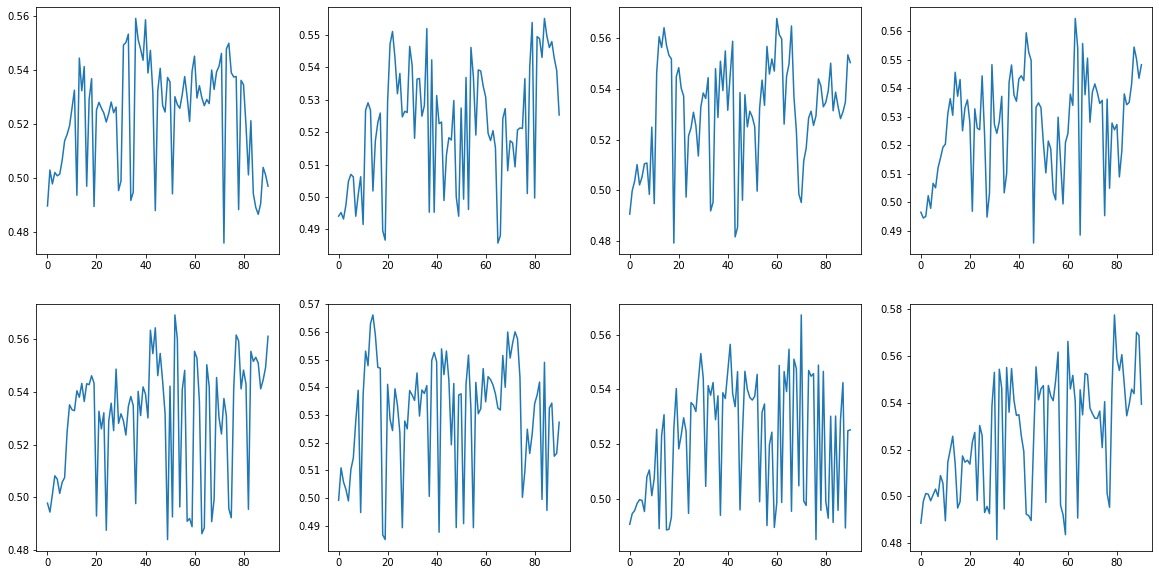

In [3]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 10)

nrows = int(params["batch_size"] / 4) + (
    params["batch_size"] - int(params["batch_size"] / 4) * 4
)
fig, ax = plt.subplots(nrows=nrows, ncols=4)

for i, series in enumerate(timeseries_results[199]["fake"]):
    ax[int(i / 4)][i % 4].plot(series[:, 0].numpy())

plt.show()